## Importación de librerías

In [1]:
import MetaTrader5 as mt5
import yfinance as yf

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
from sklearn.manifold import TSNE
from numpy.linalg import inv, eig, svd

import warnings
warnings.filterwarnings(action='ignore')

## Descarga de datos

In [2]:
def fetch_metatrader5_data(symbol, start_date, end_date, timeframe):
    if mt5.initialize():
        max_bars = 100
        timeframe_to_seconds = {
            mt5.TIMEFRAME_M1: 60,
            mt5.TIMEFRAME_M5: 300,
            mt5.TIMEFRAME_M15: 900,
            mt5.TIMEFRAME_M30: 1800,
            mt5.TIMEFRAME_H1: 3600,
            mt5.TIMEFRAME_H4: 14400,
            mt5.TIMEFRAME_D1: 86400,
            mt5.TIMEFRAME_W1: 604800
        }
        max_seconds = max_bars * timeframe_to_seconds[timeframe]
        delta = timedelta(seconds=max_seconds)
        data_frames = []
        while start_date < end_date:
            try:
                temp_end_date = min(start_date + delta, end_date)
            except OverflowError:
                print('Se ha dado la Exception')
                temp_end_date = end_date
            #print(f"{start_date} - {temp_end_date}")
            rates = mt5.copy_rates_range(symbol, timeframe, start_date, temp_end_date)
            if rates is not None and rates.size > 0:
                df = pd.DataFrame(rates[['time', 'open', 'high', 'low', 'close', 'tick_volume']])
                df['time'] = pd.to_datetime(df['time'], unit='s')
                data_frames.append(df)
            start_date = temp_end_date + timedelta(seconds=timeframe_to_seconds[timeframe])
        full_df = pd.concat(data_frames, ignore_index=True)
        if full_df['time'].duplicated().any():
            full_df = full_df.drop_duplicates(subset='time', keep='first')
        full_df = full_df.set_index('time').sort_index(ascending=True)
        return full_df

In [3]:
if mt5.initialize():
    # Obtener todos los símbolos
    symbols = mt5.symbols_get()    
    # Filtrar solo acciones (suponiendo que las acciones terminan con un cierto patrón o se pueden identificar por su descripción)
    stocks = [s.name for s in symbols if s.path.startswith("Stocks\\") or 'share' in s.description.lower()]
    tickers = random.sample(stocks, 50)
    # Fechas
    start_date = datetime(2000, 1, 1)
    end_date = datetime.now()
    timeframe = mt5.TIMEFRAME_D1
    # Descarga de datos
    dict_df = {}
    for ticker in tickers:
        df = fetch_metatrader5_data(ticker, start_date, end_date, timeframe)
        dict_df[ticker] = df['close']
    df = pd.concat(dict_df, axis=1)
    df_index = fetch_metatrader5_data('SP500', start_date, end_date, timeframe)

In [4]:
# Índice de referencia SP&500
df_index = fetch_metatrader5_data('SP500', start_date, end_date, timeframe)['close'].to_frame('close')

## Análisis exploratorio de datos

### Estadística descriptiva

In [5]:
df.shape

(4091, 50)

In [6]:
df.dropna().head()

,NDSN,SCZ,EW,SYF,TMUS,CSGP,PEG,GLW,TDOC,COTY,...,MGM,WEC,MOH,JKHY,BA,CCK,AMGN,CINF,IT,CVNA
time,,,,,,,,,,,,,,,,,,,,,
2021-01-04,196.43,68.47,88.92,34.17,132.48,89.64,55.80,34.96,200.57,6.78,...,29.69,90.38,216.23,158.98,203.08,97.24,226.70,84.42,157.74,236.35
2021-01-05,199.50,69.39,88.24,34.76,131.87,89.44,55.77,35.67,200.92,6.90,...,30.29,90.08,215.84,158.96,211.65,97.40,227.68,83.66,159.49,254.61
2021-01-06,205.07,70.29,87.15,36.92,131.60,89.63,56.99,36.90,204.59,6.96,...,31.17,91.21,235.84,161.37,211.00,100.25,233.23,87.60,163.88,251.61
2021-01-07,205.23,70.15,89.36,36.75,133.34,90.57,56.07,36.93,228.79,7.01,...,30.66,88.16,242.05,165.00,212.69,100.65,234.06,87.70,166.32,270.43
2021-01-08,202.92,70.62,90.86,36.59,135.12,92.12,57.32,36.92,227.35,6.79,...,31.36,87.96,243.24,166.95,209.95,99.62,238.73,87.77,169.16,278.33


In [7]:
df.describe()

,NDSN,SCZ,EW,SYF,TMUS,CSGP,PEG,GLW,TDOC,COTY,...,MGM,WEC,MOH,JKHY,BA,CCK,AMGN,CINF,IT,CVNA
count,3484.000000,3667.000000,4091.000000,2520.000000,2836.000000,3484.000000,3484.000000,3838.000000,2290.000000,2806.000000,...,3484.00000,3484.000000,3484.000000,3484.000000,4091.000000,3484.000000,4091.000000,3484.000000,3484.000000,1830.000000
mean,131.606693,53.116057,80.216495,33.455881,83.323614,40.262385,47.990166,24.231277,65.208349,14.375438,...,26.58149,65.285083,131.638378,106.926441,162.321244,61.293938,154.934363,73.916774,150.988424,94.530448
std,69.751592,10.531029,52.768586,6.712287,45.501413,29.549155,12.421942,8.806844,62.558029,6.742132,...,10.49788,23.060568,113.292446,53.974242,94.954607,22.908980,75.508571,29.674705,114.995754,94.264939
min,35.850000,31.590000,11.250000,12.900000,16.490000,4.660000,28.840000,7.800000,7.320000,2.670000,...,7.16000,27.960000,14.280000,24.730000,29.360000,28.500000,41.920000,24.020000,29.920000,3.720000
25%,71.447500,45.480000,36.990000,29.310000,40.032500,16.130000,36.277500,16.982500,21.420000,9.150000,...,18.64000,43.852500,38.137500,56.860000,74.280000,44.120000,70.090000,48.655000,69.417500,25.302500
50%,122.145000,52.590000,75.490000,32.740000,68.485000,27.945000,46.250000,22.200000,35.015000,12.330000,...,26.21500,62.740000,71.965000,105.135000,140.700000,53.810000,161.550000,73.305000,116.870000,57.385000
75%,201.897500,60.460000,107.075000,36.320000,129.782500,70.285000,59.522500,31.755000,77.080000,18.587500,...,33.89250,88.560000,222.825000,158.232500,211.465000,78.487500,222.595000,102.725000,180.875000,125.815000
max,278.490000,79.090000,246.200000,52.230000,191.110000,99.650000,79.720000,46.290000,294.400000,32.660000,...,50.93000,108.060000,417.930000,211.050000,441.330000,129.210000,335.750000,141.110000,499.400000,369.490000


### Visualización de datos

<Axes: title={'center': 'Matriz de correlación'}>

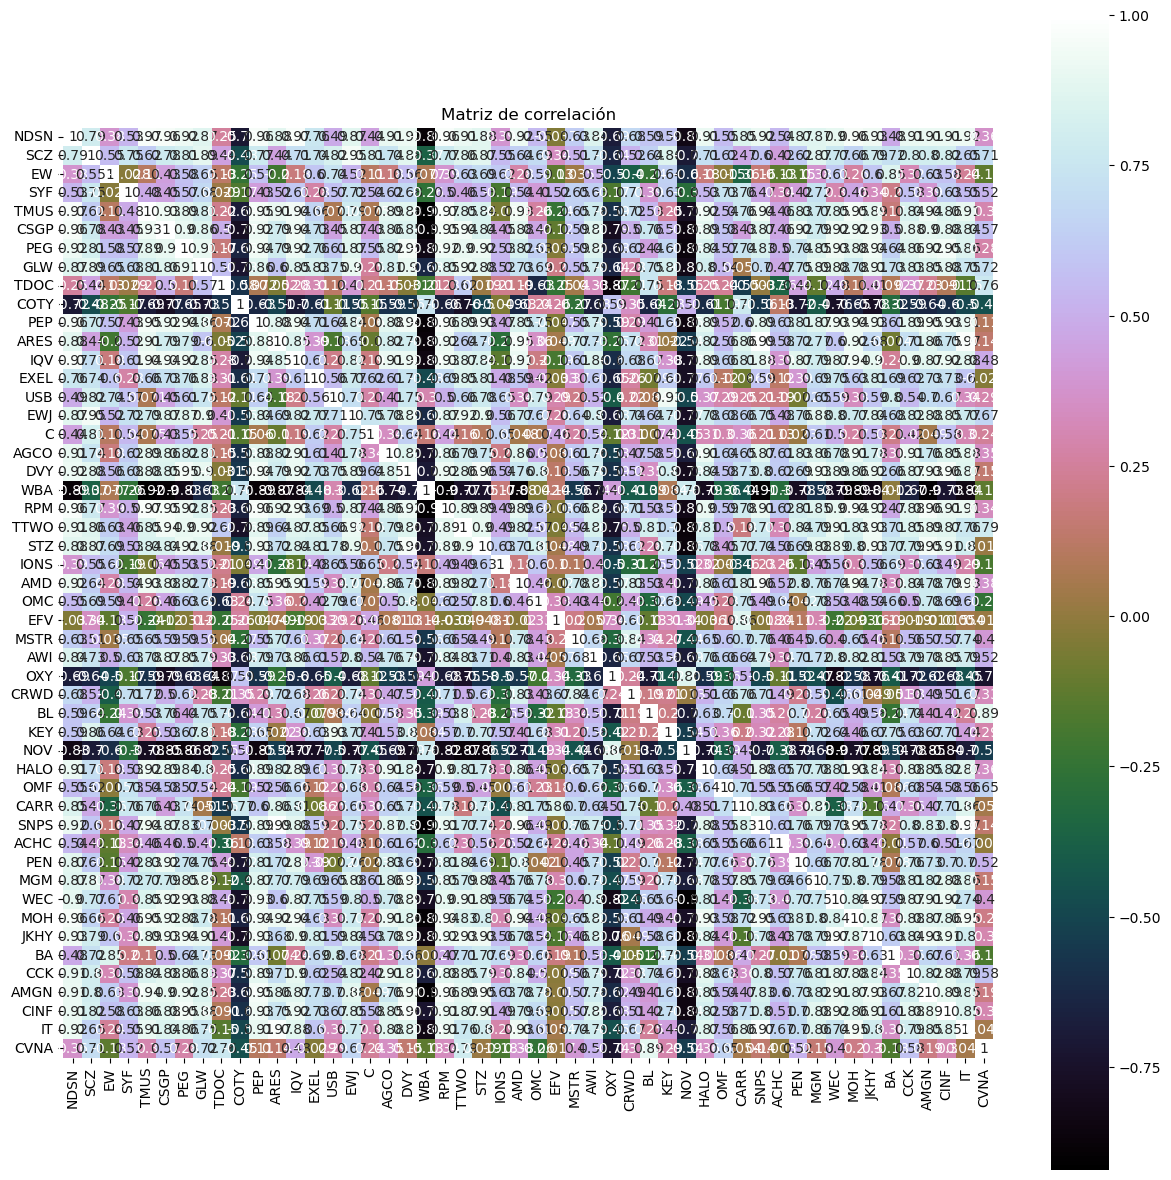

In [8]:
# Correlación
correlation = df.corr()
plt.figure(figsize=(15, 15))
plt.title('Matriz de correlación')
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

## Preparación de datos

### Limpieza de datos

In [9]:
# Eliminar columnas con 30% nulos
if df.isna().values.any():
    missing_fractions = df.isna().mean().sort_values(ascending=False)
    drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
    df = df.drop(labels=drop_list, axis=1)
    df = df.fillna(method='ffill')
    df = df.dropna()
    print(df.shape)

(3210, 37)


In [10]:
# Daily Linear Returns (%)
df_returns = df.pct_change(periods=1)
# Eliminar Outliers (> 3 x std)
df_returns = df_returns[df_returns.apply(lambda x: (x-x.mean()).abs() < (3*x.std())).all(axis=1)]

### Transformación de datos

In [11]:
# Escalado de datos
scaler = StandardScaler().fit(df_returns)
df_returns_scaled = pd.DataFrame(scaler.transform(df_returns), columns=df_returns.columns, index=df_returns.index)

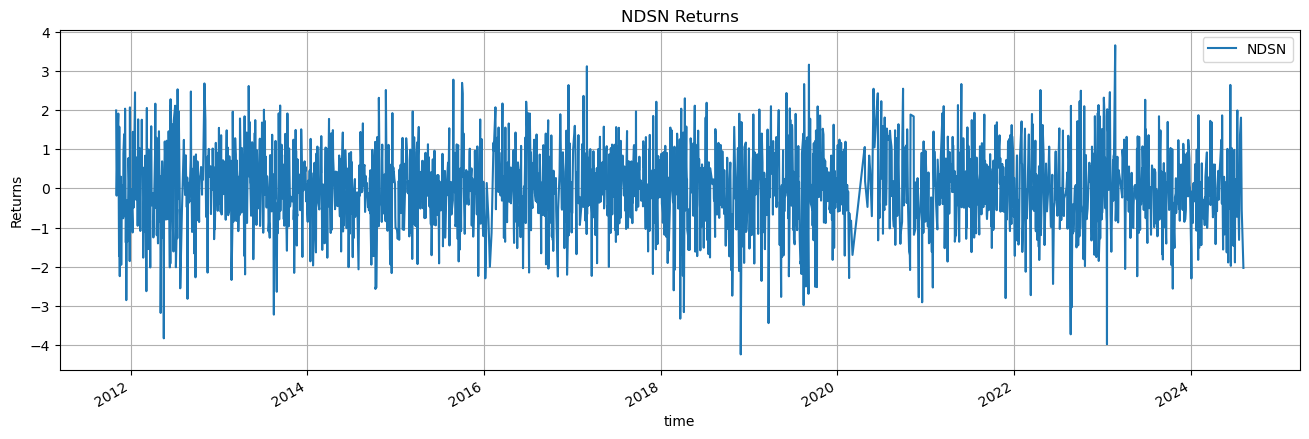

In [12]:
# Visualización escalada de los retornos de un activo
ticker = df_returns_scaled.columns.to_list()[0]
plt.figure(figsize=(16, 5))
plt.title(f'{ticker} Returns')
plt.ylabel('Returns')
df_returns_scaled[ticker].plot()
plt.grid(True)
plt.legend()
plt.show()

## Evaluación de algoritmos y modelos

In [13]:
# Dividir los datos en entrenamiento y prueba
percentage = int(len(df_returns_scaled) * 0.8)
X_train = df_returns_scaled[:percentage]
X_test = df_returns_scaled[percentage:]
X_train_raw = df_returns[:percentage]
X_test_raw = df_returns[percentage:]

In [14]:
stock_tickers = df_returns_scaled.columns.values
n_tickers = len(stock_tickers)

### Evaluación del modelo PCA

In [15]:
pca = PCA()
pca.fit(X_train)

PCA()

In [16]:
# Primer Componenente Principal / Vector Eigen
len(pca.components_[0])

37

### Varianza explicada por PCA

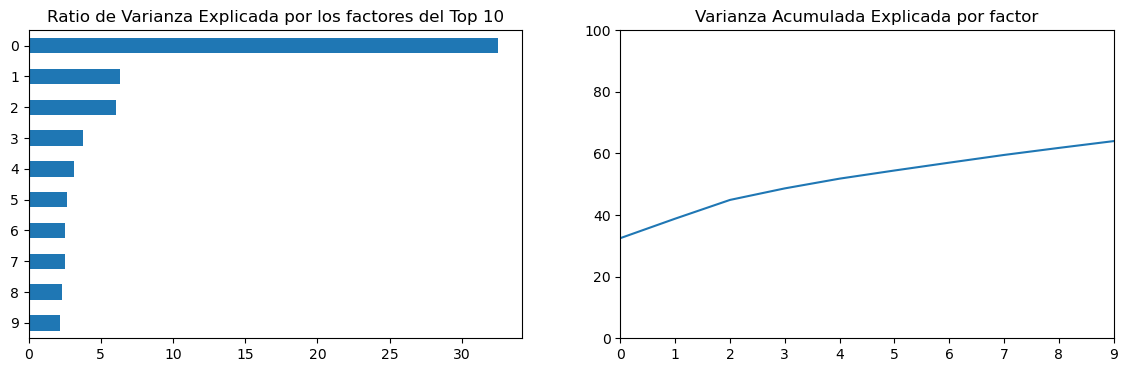

,Varianza Explicada Acumulada
0,32.52%
1,38.84%
2,44.92%
3,48.67%
4,51.83%
5,54.47%
6,57.02%
7,59.52%
8,61.81%
9,64.01%


In [17]:
num_eigen_values = 10
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
series1 = pd.Series(pca.explained_variance_ratio_[: num_eigen_values]).sort_values() * 100
series2 = pd.Series(pca.explained_variance_ratio_[:num_eigen_values]).cumsum() * 100
series1.plot.barh(ylim=(0, 9), label='woohoo', title='Ratio de Varianza Explicada por los factores del Top 10', ax=axes[0])
series2.plot(ylim=(0, 100), xlim=(0, 9), ax=axes[1], title='Varianza Acumulada Explicada por factor')
plt.show()
# Varianza explicada acumulada
pd.Series(np.cumsum(pca.explained_variance_ratio_)).to_frame('Varianza Explicada Acumulada').head(num_eigen_values).style.format('{:,.2%}'.format)

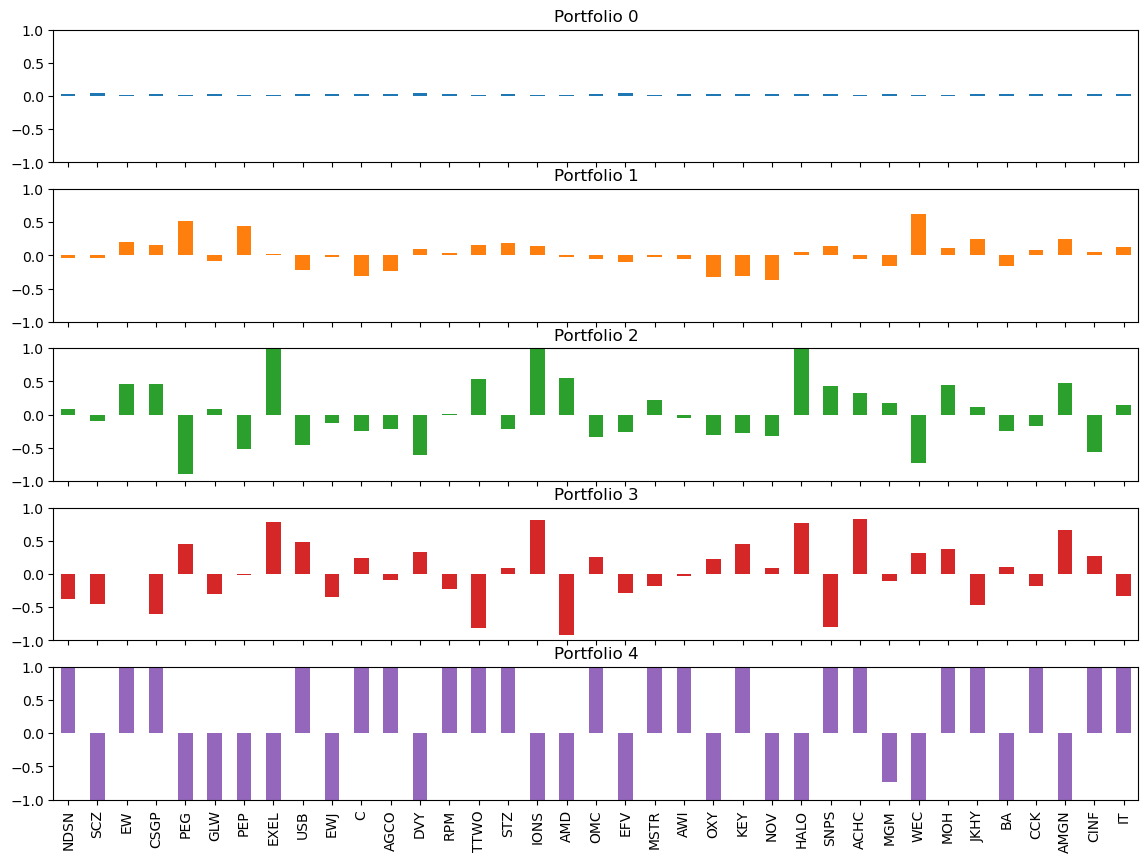

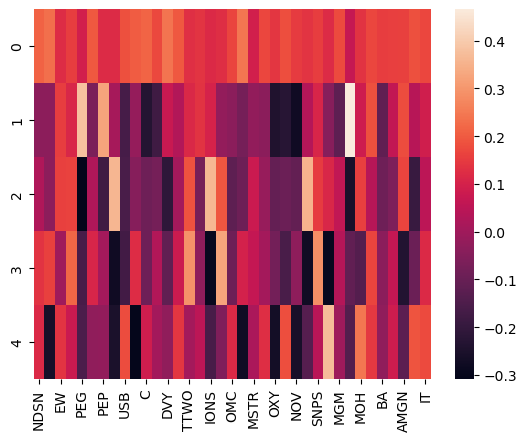

In [18]:
# Visualizando la varianza explicada del Top 5
num_components = 5
top_portfolios = pd.DataFrame(pca.components_[:num_components], columns=df_returns.columns)
eigen_portfolios = top_portfolios.div(top_portfolios.sum(1), axis=0)
eigen_portfolios.index = [f"Portfolio {i}" for i in range (num_components)]
eigen_portfolios.T.plot.bar(subplots=True, layout=(int(num_components), 1), figsize=(14, 10), legend=False, sharey=True, ylim=(-1, 1))
plt.show()
sns.heatmap(top_portfolios)
plt.show()

### Búsqueda de los pesos de los portfolios

In [19]:
# Normalizar los pesos del portfolio
def pcs_weights(pca):
    weights = np.empty_like(pca.components_)
    # Normalizar cada componente principal
    for i in range(len(pca.components_)):
        component_sum = np.sum(pca.components_[i])
        if component_sum != 0:
            weights[i] = pca.components_[i] / component_sum
        else:
            weights[i] = pca.components_[i]
    return weights

In [20]:
def optimized_portfolio(pca, pc_w, x_train_raw):
    # Sharpe Ratio function
    def sharpe_ratio(portfolio, timeframe=252):
        portfolio = portfolio.values
        n_years = len(portfolio) / timeframe
        mean = np.exp(np.log(1 + portfolio).sum() / n_years) - 1
        std = portfolio.std() * np.sqrt(timeframe)
        sharpe = mean / std
        return mean, std, sharpe
    # Cálculo del Ratio de Sharpe de cada componente principal
    n_portfolios = len(pca.components_)
    annualized_ret = np.zeros(n_portfolios)
    annualized_vol = np.zeros(n_portfolios)
    annualized_sha = np.zeros(n_portfolios)
    for i in range(n_portfolios):
        eigen_portfolio = pd.DataFrame(data={'weights': pc_w[i]*100.}, index=pca.feature_names_in_)
        eigen_portfolio_returns = np.dot(x_train_raw.loc[:, eigen_portfolio.index], pc_w[i])
        eigen_portfolio_returns = pd.Series(eigen_portfolio_returns.squeeze(), index=x_train_raw.index)
        annualized_ret[i], annualized_vol[i], annualized_sha[i] = sharpe_ratio(eigen_portfolio_returns)
        annualized_sha[i] = np.nan_to_num(annualized_sha[i], nan=0.0, posinf=0.0, neginf=0.0)
    return annualized_ret, annualized_vol, annualized_sha

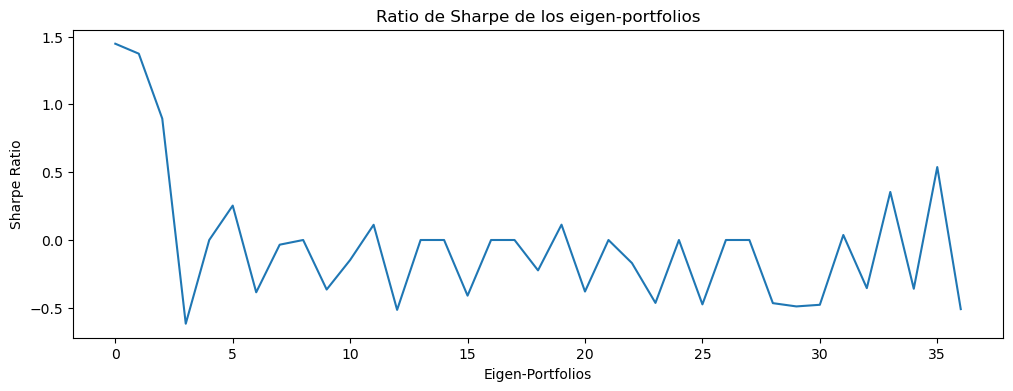

Eigen-Portfolio 0 con el mayor Ratio de Sharpe:
Retorno anualizado: 18.25%
Volatilidad anualizada: 12.61%
Ratio de Sharpe: 1.45


In [21]:
# Encontrar el portfolio con el mayor Ratio de Sharpe
pc_w= pcs_weights(pca)
pcs_returns, pcs_volatility, pcs_sharpes = optimized_portfolio(pca, pc_w, X_train_raw)
highest_sharpe_index = np.argmax(pcs_sharpes)
# Visualizando métricas de los eigen-portfolios
fig, ax = plt.subplots()
fig.set_size_inches(12, 4)
ax.plot(pcs_sharpes)
ax.set_title('Ratio de Sharpe de los eigen-portfolios')
ax.set_ylabel('Sharpe Ratio')
ax.set_xlabel('Eigen-Portfolios')
plt.show()
print(f"Eigen-Portfolio {highest_sharpe_index} con el mayor Ratio de Sharpe:\n"
      f"Retorno anualizado: {pcs_returns[highest_sharpe_index]*100.:.2f}%\n"
      f"Volatilidad anualizada: {pcs_volatility[highest_sharpe_index]*100.:.2f}%\n"
      f"Ratio de Sharpe: {pcs_sharpes[highest_sharpe_index]:.2f}")

[]

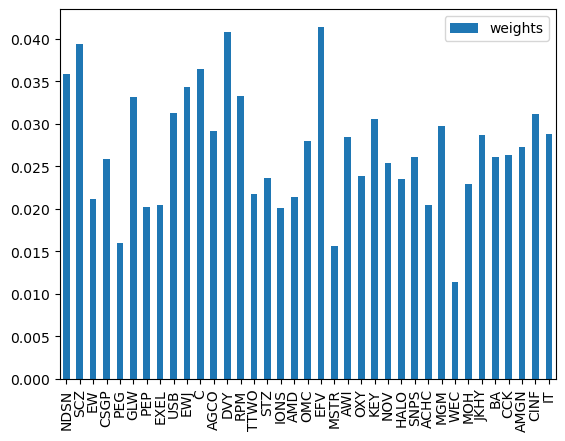

In [22]:
# Visualizando los pesos de los activos del portfolio
df_port_weights = pd.Series(data=pc_w[highest_sharpe_index], name='weights', index=pca.feature_names_in_).to_frame()
df_port_weights.plot(kind='bar')
plt.plot()

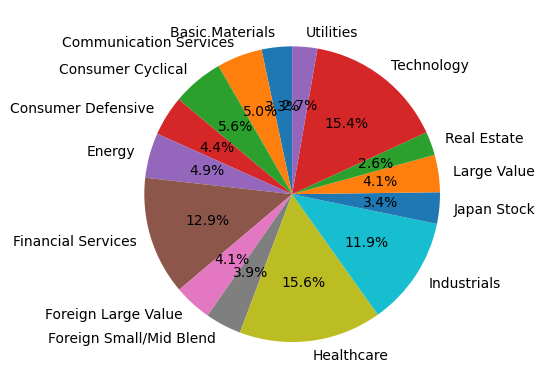

In [23]:
# Visualización de la distribución sectorial
tickers = yf.Tickers(df_port_weights.index.to_list())
tickers_type = dict()
for key, value in tickers.tickers.items():
    if 'category' in value.info.keys():
        tickers_type[key] = value.info['category']
    elif 'sector' in value.info.keys():
        tickers_type[key] = value.info['sector']
tickers_category = pd.DataFrame.from_dict(tickers_type, orient='index', columns=['sector'])
df_category_weight = pd.concat([tickers_category, df_port_weights], axis=1)
df_category_weight.groupby('sector').sum()['weights'].plot(kind='pie', 
                                                             autopct='%1.1f%%', 
                                                             startangle=90, 
                                                             ylabel='')
plt.show()

In [24]:
%run ../../../portfolio_management/functions/backtest_functions.ipynb


    __________________________________________________
    Portfolio: 
	NDSN: 3.58%
	SCZ: 3.94%
	EW: 2.11%
	CSGP: 2.58%
	PEG: 1.60%
	GLW: 3.32%
	PEP: 2.02%
	EXEL: 2.04%
	USB: 3.13%
	EWJ: 3.43%
	C: 3.65%
	AGCO: 2.92%
	DVY: 4.08%
	RPM: 3.33%
	TTWO: 2.18%
	STZ: 2.36%
	IONS: 2.01%
	AMD: 2.14%
	OMC: 2.80%
	EFV: 4.14%
	MSTR: 1.56%
	AWI: 2.84%
	OXY: 2.39%
	KEY: 3.06%
	NOV: 2.54%
	HALO: 2.36%
	SNPS: 2.61%
	ACHC: 2.04%
	MGM: 2.98%
	WEC: 1.14%
	MOH: 2.29%
	JKHY: 2.87%
	BA: 2.61%
	CCK: 2.64%
	AMGN: 2.73%
	CINF: 3.12%
	IT: 2.88%
    __________________________________________________
    Beta: 0.985
    Alpha: 0.034
    Sharpe: 0.835
    Sortino: 1.049
    ___________________________________________________
    VaR: -14.802
    cVaR: -22.871
    ___________________________________________________
    


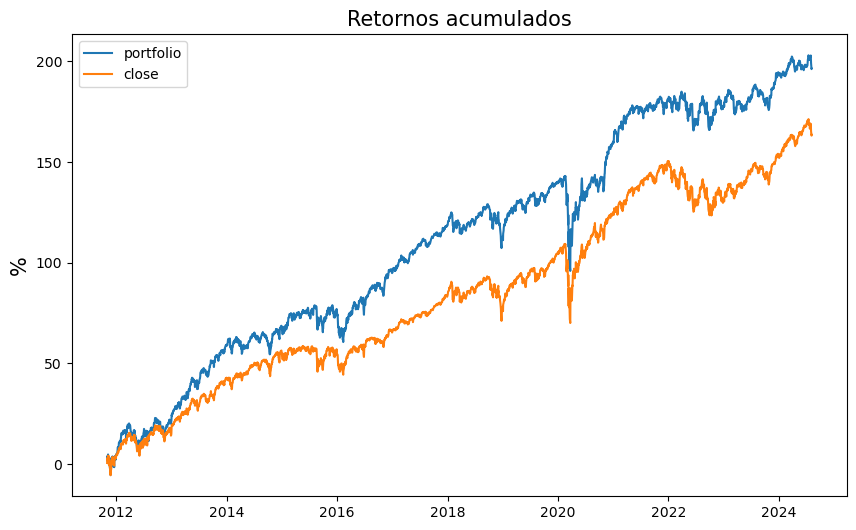

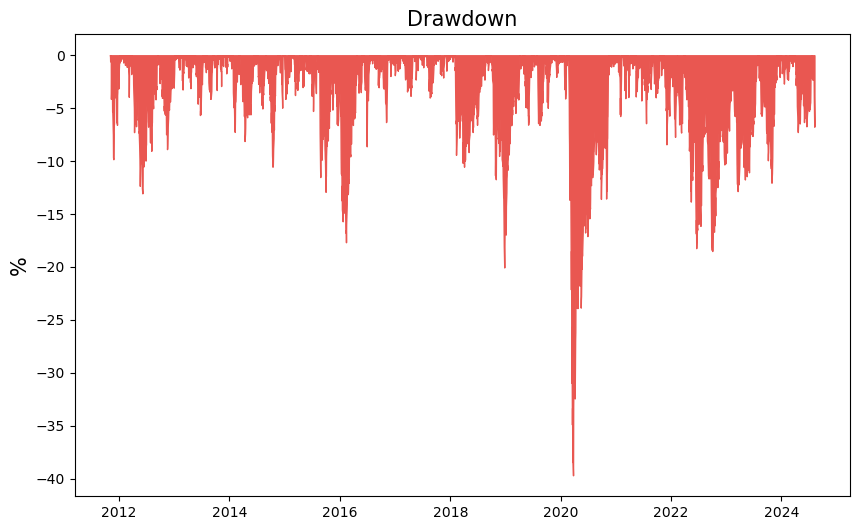

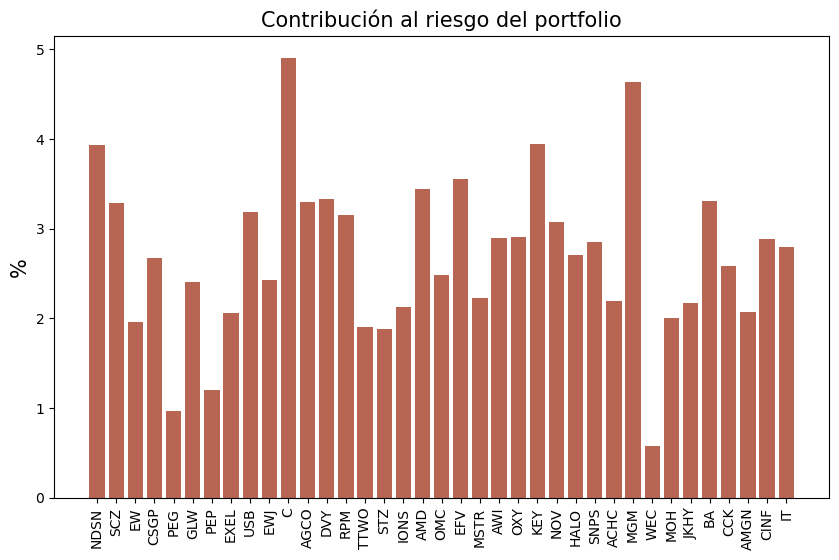

In [26]:
df_port_returns = df.pct_change().dropna()
df_index_returns = df_index.loc[df.index.min():df.index.max()].pct_change().dropna()
static_backtest_function(df_port_weights, df_port_returns, df_index_returns)